In [12]:
%matplotlib inline
import matplotlib.animation as ani
import matplotlib.colors as colors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from planetThermo import pco2
from planetThermo import tco2
import scipy.linalg
from scipy.stats import binned_statistic_2d as bin2d
from scipy.fft import fft
from scipy.interpolate import pchip
from scipy import interpolate
from scipy.integrate import trapz
import statsmodels.api as sm
import netCDF4 as nc
import pickle
import matplotlib.ticker as mticker
import scipy.ndimage as ndimage
from operator import itemgetter
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from functools import partial
import geopandas
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata
from geocube.rasterize import rasterize_points_griddata
from cartopy import config
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import scipy.ndimage as ndimage
from operator import itemgetter

plt.rc('font', family='serif')
plt.rcParams['font.weight']= 'heavy'
plt.rcParams.update({'font.size': 11})

from scipy.interpolate import interp2d

In [2]:
#I've saved the binning routines to a module python file

#List of binning methods:

#binning in longitude and latitude:    
from MCS_Vortex_modules import Lat_Long_binning

#polar vortex column density function for north:
from MCS_Vortex_modules import North_Polar_Column_Density as NPolar_Column_Density

#polar vortex column density function for south:
from MCS_Vortex_modules import South_Polar_Column_Density as SPolar_Column_Density


#import the Polar vortex analysis functions:
from MCS_Vortex_modules import fill_gaps
from MCS_Vortex_modules import contour_fit
from MCS_Vortex_modules import centroid_point

In [5]:
def make_mask(mainarray, mask_edges):
    '''given bounding edges of masked areas, create masked version of the array'''
    
    #(for north pole I have to convert from LS units to the index, since the LS starts at 180)
    if mask_edges[0][0]> 180:
        ME_index = mask_edges - 180
    else:
        ME_index = mask_edges
        
    #create array of ones in the same length as original array:
    masks = np.ones([len(mainarray)])
    for i in range(len(mask_edges)):
        a = ME_index[i][0]
        b = ME_index[i][1]
        masks[a:b] = np.zeros(b-a)
        
    main_masked = np.ma.array(mainarray,mask = masks)
    
    new_array = np.where(masks, mainarray, np.nan)
    
    return new_array


In [6]:
def find_nearest_idx(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = abs(a - a0).argmin()
    return idx

In [16]:
#reading from parquet file

#### NORTH ####

#df = pd.read_parquet('../Datasets/MCS_MY29_20081225_20091026.parquet.gzip'); yr = 29 ;df.replace(0, np.nan, inplace=True); removeables = ['215.0','219.0','270.0'] ; missing_Ls = [215 ,270,279, 317, 328] ; dups = [5,1,2,2,32]
#df = pd.read_parquet('../Datasets/MCS_MY30_20101112_20110913.parquet.gzip'); yr = 30 ;df.replace(0, np.nan, inplace=True); removeables = ['189.0','311.0'] ; missing_Ls = [189, 311] ; dups = [1,1]
#df = pd.read_parquet('../Datasets/MCS_MY31_20120731_20130731.parquet.gzip'); yr = 31 ;df.replace(0, np.nan, inplace=True); removeables = ['262.0','293.0'] ; missing_Ls = [189, 262, 293] ; dups = [1,1,1]
#df = pd.read_parquet('../Datasets/MCS_MY32_20130713_20150618.parquet.gzip'); yr = 32 ;df.replace(0, np.nan, inplace=True); removeables = ['190.0','194.0','248.0'] ; missing_Ls = [186, 190, 194, 248, 319] ; dups = [1,1,1,1,1]
#df = pd.read_parquet('../Datasets/MCS_MY33_20150618_20170505.parquet.gzip'); yr = 33 ;df.replace(0, np.nan, inplace=True); removeables = [] ; missing_Ls = [180,245] ; dups = [1,2]
#df = pd.read_parquet('../Datasets/MCS_MY34_20170505_20190322.parquet.gzip'); yr = 34 ; df.replace(0, np.nan, inplace=True); removeables = ['190.0','221.0','222.0','262.0','269.0','280.0','297.0'] ; missing_Ls = [190,220, 262,270, 296] ; dups = [1,4,1,10,1]
df = pd.read_parquet('../Datasets/MCS_MY35_20200408_20210207.parquet.gzip'); yr = 35  ;df.replace(0, np.nan, inplace=True);  removeables = ['183.0','187.0','213.0','299.0'] ;  missing_Ls = [183,213, 219, 296] ; dups = [5,1,4,3]


In [1017]:
#longitude bin size
longbinsiz = 1
latbinsiz = 1

#latitude cut off:
latcut = 30 #Polar vortex in north does not extend beyond this value ever

# create a new dataframe that only includes the north polar vortex
NPV = df[(df.LS <= 360)&(df.LS >=180)&(df.ALTITUDE <= 20)&(df.ALTITUDE >= 10)&(df.LATITUDE >= latcut)]
#resetting index of new dataframe
NPV = NPV.reset_index()
NPV = NPV.drop(['index'],axis = 1)
#calculate the frost point for each entry
NPV['T_frost'] = tco2(0.95*NPV.PRESSURE)

#bin the data
LatV,LongV, Vtemp = Lat_Long_binning(NPV,'temp',longbinsiz,latbinsiz,latcut,90,-180,180)
LatV,LongV, Vfrost= Lat_Long_binning(NPV,'tfrost',longbinsiz,latbinsiz,latcut,90,-180,180)


names = list(Vtemp.keys())

for i in removeables:
    names.remove(i)

intnames = np.array(names).astype(float).astype(int)


100%|█████████████████████████████████████████| 166/166 [00:02<00:00, 64.86it/s]


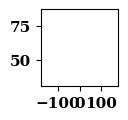

In [1019]:
#create empty array to store polar vortex temps for each Ls
Vortex_T = np.zeros(len(names))
Vortex_Frost = np.zeros(len(names))

#create empty array to store polar vortex area for each Ls
Vortex_Area = np.zeros(len(names))
#create empty array to store the latitude extent of a perfect circle encompassing the polar vortex area
eq_lat = np.zeros(len(names))

#create empty array to store the number of non-nan entries for use in filtering:
count = np.zeros(len(names))

intnames = np.array(names).astype(float).astype(int)
plt.figure(figsize=[1,1])
for i in tqdm(range(len(intnames))):
    
    #number of non-nans:
    count[i] = np.count_nonzero(~np.isnan(Vtemp[names[i]]))
    
    #fill in missing data
    interp_temps,longv,latv = fill_gaps(Vtemp[names[i]].T,LongV,LatV)
    interp_frost,longv,latv = fill_gaps(Vfrost[names[i]].T,LongV,LatV)
    
    #find the polar vortex boundary and mask the data outside of the vortex for the mean temp calculations
    #find contour of 170 == pv boundary
    cp = plt.contour(longv,latv,interp_temps, [170], alpha = 0)
    Longs, Lats = contour_fit(cp)
    
    #create the mask
    mask = np.zeros(interp_temps.shape)
    
    for j in range(mask.shape[1]):
        #mask everything outside 70 (20 = 90-70 (edge of data))
        edge_index = 40
        mask[:edge_index,j] = np.ones([edge_index])
        
    #mask both temp and frost temp matrices
    masked_temps = np.ma.masked_array(interp_temps, mask)
    masked_frost = np.ma.masked_array(interp_frost, mask)
    
    
    #calculate the average and median temperature in the vortex
    Av_temp = np.nanmean(masked_temps)
    Av_frost = np.nanmean(masked_frost)
    
    
    Vortex_T[i] = Av_temp 
    Vortex_Frost[i] = Av_frost
    
    #calculate the Area inside the contour:
    area_around = trapz(np.abs(Lats)-np.abs(latcut))
    polar_area = (90-np.abs(latcut))*360 - area_around
    Vortex_Area[i]= polar_area
    #also save the equivalent lat of a circle drawn closest to boundary
    eq_lat[i] = np.mean(Lats)


In [1020]:
Vortex_Area35 = Vortex_Area
Eq_Lat35 = eq_lat
Vortex_Frost35 = Vortex_Frost
Vortex_T35 = Vortex_T
names35 = np.array(names).astype(float).astype(int)

In [17]:
#Creating the polar cloud density plots

#set limits and bin size for latitude
latmin = 70
latmax = 88
latbinsiz = 2

#set limits and bin size for longitude
longbinsiz = 20
longmin = -180
longmax = 180

#using function in module, save the results
Polar_Clouds = NPolar_Column_Density(df, latmin,latmax,latbinsiz,longmin,longmax,longbinsiz)

#Polar_Clouds.to_csv('MY35_NorthWinter_Longitude_Clouds_70-88.zip', index=False)  

100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.51it/s]


## 
## SOUTH POLE

In [7]:
#reading from parquet file

#### SOUTH ####

df = pd.read_parquet('../Datasets/MCS_MY29_20071209_20081225.parquet.gzip'); yr = 29  ;df.replace(0, np.nan, inplace=True);yr=29;removeables = ['33.0','61.0', '64.0', '104.0','137.0', '138.0', '144.0']
#df = pd.read_parquet('../Datasets/MCS_MY30_20091026_20101112.parquet.gzip'); yr = 30  ; df.replace(0, np.nan, inplace=True); yr = 30 ;removeables = []
#df = pd.read_parquet('../Datasets/MCS_MY31_20110913_20120731.parquet.gzip'); yr = 31  ; df.replace(0, np.nan, inplace=True); yr = 31 ;removeables = ['71.0']
#df = pd.read_parquet('../Datasets/MCS_MY32_20130713_20150618.parquet.gzip'); yr = 32  ; df.replace(0, np.nan, inplace=True); yr = 32 ;removeables = ['108.0','114.0','118.0', '119.0', '120.0', '121.0', '122.0', '123.0', '124.0', '125.0', '126.0', '127.0', '128.0', '129.0', '130.0', '131.0', '132.0', '133.0', '134.0', '135.0', '136.0', '137.0', '138.0', '139.0', '140.0', '141.0', '142.0', '143.0', '144.0', '145.0', '146.0', '147.0', '148.0', '149.0', '150.0']
#df = pd.read_parquet('../Datasets/MCS_MY33_20150618_20170505.parquet.gzip'); yr = 33  ; df.replace(0, np.nan, inplace=True); yr = 33 ;removeables = ['63.0', '64.0', '100.0', '177.0']
#df = pd.read_parquet('../Datasets/MCS_MY34_20170505_20190322.parquet.gzip'); yr = 34 ; df.replace(0, np.nan, inplace=True); yr = 34 ;removeables = ['31.0','38.0','42.0','44.0','60.0','130.0', '137.0', '138.0']
#df = pd.read_parquet('../Datasets/MCS_MY35_20190322_20200408.parquet.gzip'); yr = 35  ; df.replace(0, np.nan, inplace=True); yr = 35 ;removeables = ['157.0']

In [1256]:
#longitude bin size
longbinsiz = 1
latbinsiz = 1

#latitude cut off:
latcut = -30 #Polar vortex does not extend beyond this value ever

# create a new dataframe that only includes the south polar vortex
SPV = df[(df.LS <= 180)&(df.LS >=0)&(df.ALTITUDE <= 20)&(df.ALTITUDE >= 10)&(df.LATITUDE <= latcut)]
#resetting index of new dataframe
SPV = SPV.reset_index()
SPV = SPV.drop(['index'],axis = 1)
#calculate the frost point for each entry
SPV['T_frost'] = tco2(0.95*SPV.PRESSURE)

#bin the data
LatV,LongV, Vtemp = Lat_Long_binning(SPV,'temp',longbinsiz,latbinsiz,-90,latcut,-180,180)
LatV,LongV, Vfrost= Lat_Long_binning(SPV,'tfrost',longbinsiz,latbinsiz,-90,latcut,-180,180)


names = list(Vtemp.keys())

for i in removeables:
    names.remove(i)

intnames = np.array(names).astype(float).astype(int)

100%|█████████████████████████████████████████| 169/169 [00:02<00:00, 59.53it/s]


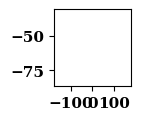

In [1257]:
#create empty array to store polar vortex temps for each Ls
Vortex_T = np.zeros(len(names))
Vortex_Frost = np.zeros(len(names))

#create empty array to store polar vortex area for each Ls
Vortex_Area = np.zeros(len(names))
#create empty array to store the latitude extent of a perfect circle encompassing the polar vortex area
eq_lat = np.zeros(len(names))

#create empty array to store the number of non-nan entries for use in filtering:
count = np.zeros(len(names))
intnames = np.array(names).astype(float).astype(int)
plt.figure(figsize=[1,1])
for i in tqdm(range(len(intnames))):
    #number of non-nans:
    count[i] = np.count_nonzero(~np.isnan(Vtemp[names[i]]))
    #fill in missing data
    interp_temps,longv,latv = fill_gaps(Vtemp[names[i]].T,LongV,LatV)
    interp_frost,longv,latv = fill_gaps(Vfrost[names[i]].T,LongV,LatV)
    
    #find the polar vortex boundary and mask the data outside of the vortex for the mean temp calculations
    #find contour of 170 == pv boundary
    cp = plt.contour(longv,latv,interp_temps, [170], alpha = 0)
    Longs, Lats = contour_fit(cp)
    #create the mask
    mask = np.ones(interp_temps.shape)
    stepsiz = round(len(Lats)/interp_temps.shape[1])
    Latidx = Lats[0::stepsiz]
    #for j in range(len(Latidx)-1):
    #    edge_index = find_nearest_idx(LatV, Latidx[j])-1
    #    mask[:edge_index,j] = np.zeros([edge_index])
    
    for j in range(mask.shape[1]):
        #mask everything outside of -65 for south
        edge_index = find_nearest_idx(LatV, -65)
        mask[:edge_index,j] = np.zeros([edge_index])
        
    #mask both temp and frost temp matrices
    masked_temps = np.ma.masked_array(interp_temps, mask)
    masked_frost = np.ma.masked_array(interp_frost, mask)
    
    #calculate the average and median temperature in the vortex
    Av_temp = np.nanmean(masked_temps)
    Av_frost = np.nanmean(masked_frost)
    
    Vortex_T[i] = Av_temp
    Vortex_Frost[i] = Av_frost 
    
    #calculate the Area inside the contour:
    area_around = trapz(np.abs(Lats)-np.abs(latcut))
    polar_area = (90-np.abs(latcut))*360 - area_around
    Vortex_Area[i]= polar_area
    #also save the equivalent lat of a circle drawn closest to boundary
    eq_lat[i] = np.mean(Lats)


In [1258]:
Vortex_Area29 = Vortex_Area
Eq_Lat29 = eq_lat
Vortex_Frost29 = Vortex_Frost
Vortex_T29 = Vortex_T
names29 = np.array(names).astype(float).astype(int)
C29  = count

In [8]:
#Creating the polar cloud density plots

#set limits and bin size for latitude
latmin = -88
latmax = -70
latbinsiz = 2
#set limits and bin size for longitude
longbinsiz = 20
longmin = -180
longmax = 180

#using function in module, save the results
Polar_Clouds = SPolar_Column_Density(df, latmin,latmax,latbinsiz,longmin,longmax,longbinsiz)
#Polar_Clouds.to_csv('MY29_SouthWinter_Longitude_Clouds_70-88.zip', index=False)  

100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.13it/s]


## 
## SAVING THE DATA

In [1259]:
a29 = pd.DataFrame(names29)
a29.columns = ['Ls']
a29['Temp'] = Vortex_T29
a29['Tfrost'] = Vortex_Frost29
a29.set_index('Ls',inplace=True)

a30 = pd.DataFrame(names30)
a30.columns = ['Ls']
a30['Temp'] = Vortex_T30
a30['Tfrost'] = Vortex_Frost30
a30.set_index('Ls',inplace=True)

a31 = pd.DataFrame(names31)
a31.columns = ['Ls']
a31['Temp'] = Vortex_T31
a31['Tfrost'] = Vortex_Frost31
a31.set_index('Ls',inplace=True)

a32 = pd.DataFrame(names32)
a32.columns = ['Ls']
a32['Temp'] = Vortex_T32
a32['Tfrost'] = Vortex_Frost32
a32.set_index('Ls',inplace=True)

a33 = pd.DataFrame(names33)
a33.columns = ['Ls']
a33['Temp'] = Vortex_T33
a33['Tfrost'] = Vortex_Frost33
a33.set_index('Ls',inplace=True)

a34 = pd.DataFrame(names34)
a34.columns = ['Ls']
a34['Temp'] = Vortex_T34
a34['Tfrost'] = Vortex_Frost34
a34.set_index('Ls',inplace=True)

a35 = pd.DataFrame(names35)
a35.columns = ['Ls']
a35['Temp'] = Vortex_T35
a35['Tfrost'] = Vortex_Frost35
a35.set_index('Ls',inplace=True)

Vortex_Temps = pd.concat([a29, a30, a31, a32, a33, a34, a35], axis=1)
Vortex_Temps.columns = ['Temp29','Tfrost29','Temp30','Tfrost30','Temp31','Tfrost31','Temp32','Tfrost32','Temp33','Tfrost33','Temp34','Tfrost34','Temp35','Tfrost35']
Vortex_Temps.sort_index(inplace=True)
Vortex_Temps.reset_index(inplace=True)

In [1260]:
a29 = pd.DataFrame(names29)
a29.columns = ['Ls']
a29['Area'] = Vortex_Area29
a29['Lat'] = Eq_Lat29
a29.set_index('Ls',inplace=True)

a30 = pd.DataFrame(names30)
a30.columns = ['Ls']
a30['Area'] = Vortex_Area30
a30['Lat'] = Eq_Lat30
a30.set_index('Ls',inplace=True)

a31 = pd.DataFrame(names31)
a31.columns = ['Ls']
a31['Area'] = Vortex_Area31
a31['Lat'] = Eq_Lat31
a31.set_index('Ls',inplace=True)

a32 = pd.DataFrame(names32)
a32.columns = ['Ls']
a32['Area'] = Vortex_Area32
a32['Lat'] = Eq_Lat32
a32.set_index('Ls',inplace=True)

a33 = pd.DataFrame(names33)
a33.columns = ['Ls']
a33['Area'] = Vortex_Area33
a33['Lat'] = Eq_Lat33
a33.set_index('Ls',inplace=True)

a34 = pd.DataFrame(names34)
a34.columns = ['Ls']
a34['Area'] = Vortex_Area34
a34['Lat'] = Eq_Lat34
a34.set_index('Ls',inplace=True)

a35 = pd.DataFrame(names35)
a35.columns = ['Ls']
a35['Area'] = Vortex_Area35
a35['Lat'] = Eq_Lat35
a35.set_index('Ls',inplace=True)

Vortex_Areas = pd.concat([a29, a30, a31, a32, a33, a34,a35], axis=1)
Vortex_Areas.columns = ['Area29', 'Lat29','Area30', 'Lat30','Area31','Lat31','Area32','Lat32','Area33','Lat33','Area34','Lat34','Area35','Lat35']
Vortex_Areas.sort_index(inplace=True)
Vortex_Areas.reset_index(inplace=True)

In [1283]:
#Save Vortex Temps dataframe
#North
#Vortex_Temps.to_csv('Vortex_Temps_NorthWinter_MY29-35.zip', index=False)  
#South 
Vortex_Temps.to_csv('Vortex_Temps_SouthWinter_MY29-35.zip', index=False)  


In [1284]:
#Save Vortex Area dataframe
#North
#Vortex_Areas.to_csv('Vortex_Areas_NorthWinter_MY29-35.zip', index=False) 
#South
Vortex_Areas.to_csv('Vortex_Areas_SouthWinter_MY29-35.zip', index=False) 

## PLOTTING 

In [1286]:
#LOAD IN NORTH RESULTS
#to read the data for plotting:
# Load data (deserialize)
with open('../Results/32MICRON_North_Snowfall_Results_No_Outliers.pickle', 'rb') as handle:
    North_results = pickle.load(handle)

In [1287]:
#read results in for North

Water_deposit29_B  =  North_results['Water_deposit29'] 
CO2_deposit29_B    =  North_results['CO2_deposit29']   
Mass_deposit29_B   =  North_results['Mass_deposit29']  
CMass_deposit29_B  =  North_results['CMass_deposit29'] 
Water_cum29      =  North_results['Water_cum29']       
Mass_cum29       =  North_results['Mass_cum29']        
DryIce_cum29     =  North_results['DryIce_cum29']      
CMass_cum29      =  North_results['CMass_cum29']       

#MY30
Water_deposit30_B =  North_results['Water_deposit30'] 
CO2_deposit30_B   =  North_results['CO2_deposit30']   
Mass_deposit30_B  =  North_results['Mass_deposit30']  
CMass_deposit30_B =  North_results['CMass_deposit30'] 
Water_cum30     =  North_results['Water_cum30']       
Mass_cum30      =  North_results['Mass_cum30']        
DryIce_cum30    =  North_results['DryIce_cum30']      
CMass_cum30     =  North_results['CMass_cum30']       

#MY31
Water_deposit31_B =  North_results['Water_deposit31'] 
CO2_deposit31_B   =  North_results['CO2_deposit31']   
Mass_deposit31_B  =  North_results['Mass_deposit31']  
CMass_deposit31_B =  North_results['CMass_deposit31'] 
Water_cum31     =  North_results['Water_cum31']       
Mass_cum31      =  North_results['Mass_cum31']        
DryIce_cum31    =  North_results['DryIce_cum31']      
CMass_cum31     =  North_results['CMass_cum31']       

#MY32
Water_deposit32_B =  North_results['Water_deposit32'] 
CO2_deposit32_B   =  North_results['CO2_deposit32']   
Mass_deposit32_B  =  North_results['Mass_deposit32']  
CMass_deposit32_B =  North_results['CMass_deposit32'] 
Water_cum32     =  North_results['Water_cum32']       
Mass_cum32      =  North_results['Mass_cum32']        
DryIce_cum32    =  North_results['DryIce_cum32']      
CMass_cum32     =  North_results['CMass_cum32']       

#MY33
Water_deposit33_B =  North_results['Water_deposit33'] 
CO2_deposit33_B   =  North_results['CO2_deposit33']   
Mass_deposit33_B  =  North_results['Mass_deposit33']  
CMass_deposit33_B =  North_results['CMass_deposit33'] 
Water_cum33     =  North_results['Water_cum33']       
Mass_cum33      =  North_results['Mass_cum33']        
DryIce_cum33    =  North_results['DryIce_cum33']      
CMass_cum33     =  North_results['CMass_cum33']       

#MY34
Water_deposit34_B =  North_results['Water_deposit34'] 
CO2_deposit34_B   =  North_results['CO2_deposit34']   
Mass_deposit34_B  =  North_results['Mass_deposit34']  
CMass_deposit34_B =  North_results['CMass_deposit34'] 
Water_cum34     =  North_results['Water_cum34']       
Mass_cum34      =  North_results['Mass_cum34']        
DryIce_cum34    =  North_results['DryIce_cum34']      
CMass_cum34  =  North_results['CMass_cum34']       


#MY35
Water_deposit35_B =  North_results['Water_deposit35'] 
CO2_deposit35_B   =  North_results['CO2_deposit35']   
Mass_deposit35_B  =  North_results['Mass_deposit35']  
CMass_deposit35_B =  North_results['CMass_deposit35'] 
Water_cum35     =  North_results['Water_cum35']       
Mass_cum35      =  North_results['Mass_cum35']        
DryIce_cum35    =  North_results['DryIce_cum35']      
CMass_cum35  =  North_results['CMass_cum35']  

#calculate the average co2 snowfall per year, disregarding MY 34 with dust storm
CO2_stack = np.stack([CO2_deposit29_B,CO2_deposit30_B,CO2_deposit31_B,CO2_deposit32_B,CO2_deposit33_B ,CO2_deposit35_B])
CO2_median = np.median(CO2_stack, axis = 0)
CO2_mean = np.mean(CO2_stack, axis = 0)
#TOTAL CO2 MULTIPLE YEARS AVERAGE
sigmaval = 3
smooth_avCO2 = gaussian_filter(CO2_median, sigma=sigmaval)
avCO2_total = np.nanmean(smooth_avCO2, axis = 1)


#create the latitude arrays associated with the results in the previous two cells for the norht and south pole>
LatV = np.array([65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87.])

In [1288]:
#Read in Vortex Area dataframe:
Vortex_Areas = pd.read_csv('../Results/Vortex_Areas_NorthWinter_MY29-35.zip')  

#Read in Vortex Temps dataframe:
Vortex_Temps = pd.read_csv('../Results/Vortex_Temps_NorthWinter_MY29-35.zip')  

#calculate the av temps one way
Vortex_Temps['MnTemp'] = Vortex_Temps[['Temp29', 'Temp30','Temp31','Temp32','Temp33','Temp35']].median(axis=1)
Vortex_Temps['MnFrostTemp'] = Vortex_Temps[['Tfrost29', 'Tfrost30','Tfrost31','Tfrost32','Tfrost33','Tfrost35']].median(axis=1)

In [1290]:
#Create Masks for the temperature plots over the times where there are dust storms, so that I can get the average baseline without duststorm effects
#define the edges of the boundaries for the masks
m29_edges = np.array([(233,260),(308,326)])
m31_edges = np.array([(208,225),(310,329)])
m32_edges = np.array([(218,243),(309,341)])
m33_edges = np.array([(218,230),(320,344)])
m34_edges = np.array([(187,276),(319,337)])
m35_edges = np.array([(225,250),(314,332)])


window = 4
order = 1

smooth_diff29   =   savgol_filter(np.array(Vortex_Temps['Temp29'])-np.array(Vortex_Temps['Tfrost29']),window, order)
smooth_diff30   =   savgol_filter(np.array(Vortex_Temps['Temp30'])-np.array(Vortex_Temps['Tfrost30']),window, order)
smooth_diff31   =   savgol_filter(np.array(Vortex_Temps['Temp31'])-np.array(Vortex_Temps['Tfrost31']),window, order)
smooth_diff32   =   savgol_filter(np.array(Vortex_Temps['Temp32'])-np.array(Vortex_Temps['Tfrost32']),window, order)
smooth_diff33   =   savgol_filter(np.array(Vortex_Temps['Temp33'])-np.array(Vortex_Temps['Tfrost33']),window, order)
smooth_diff34   =   savgol_filter(np.array(Vortex_Temps['Temp34'])-np.array(Vortex_Temps['Tfrost34']),window, order)
smooth_diff35   =   savgol_filter(np.array(Vortex_Temps['Temp35'])-np.array(Vortex_Temps['Tfrost35']),window, order)


T29  = make_mask(smooth_diff29,m29_edges)
T30  = smooth_diff30
T31  = make_mask(smooth_diff31,m31_edges)
T32  = make_mask(smooth_diff32,m32_edges)
T33  = make_mask(smooth_diff33,m33_edges)
T34  = make_mask(smooth_diff34,m34_edges)
T35  = make_mask(smooth_diff35,m35_edges)


Av_Temp_diff = np.nanmean([T29,T30,T31,T32,T33,T35],axis=0)

smoothed_temp_diff =  savgol_filter(Av_Temp_diff,6, 1)

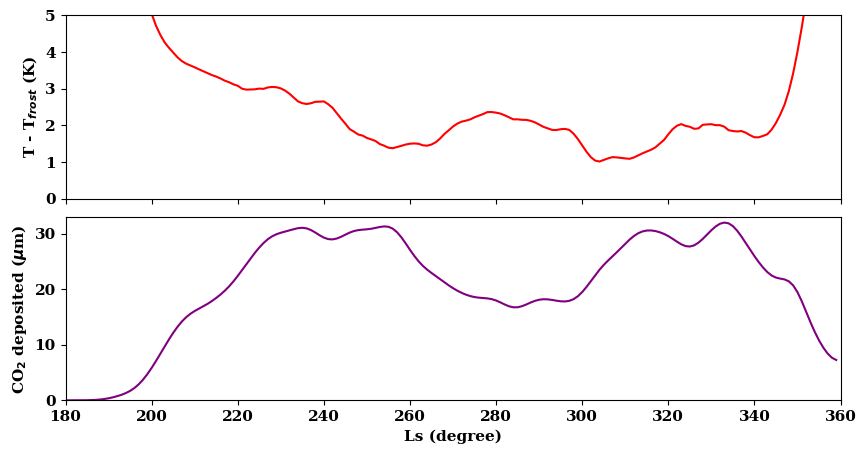

In [1291]:
#plot the temp diff with co2 snowfall for north

fullnames = np.linspace(180,360,181)
figure, (ax0,ax1) = plt.subplots(2, 1, figsize=(10,5), sharex=True)

plt.subplots_adjust(hspace=.1)
#ax0.plot(Vortex_Temps['Ls'],Vortex_Temps['MnTemp']-Vortex_Temps['MnFrostTemp'],'r')
ax0.plot(Vortex_Temps['Ls'],smoothed_temp_diff,'r')



ax0.set_xlim(180,360)
ax0.set_ylim(0,5)
ax0.set_ylabel('T - T$_{frost}$ (K)',weight = 'bold')

ax1.plot(fullnames[:-1],avCO2_total*1e6,color = 'purple')
ax1.set_ylabel('CO$_2$ deposited ($\mu$m)', weight='bold')
ax1.set_ylim(0,33)
ax1.set_xlabel('Ls (degree)',fontweight='bold')


plt.savefig("Solstitial_North_Warming.png", dpi=200)

In [19]:
#polar density plots

#first download the data

Polar_Clouds35 = pd.read_csv('../Results/MY35_NorthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds34 = pd.read_csv('../Results/MY34_NorthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds33 = pd.read_csv('../Results/MY33_NorthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds32 = pd.read_csv('../Results/MY32_NorthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds31 = pd.read_csv('../Results/MY31_NorthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds30 = pd.read_csv('../Results/MY30_NorthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds29 = pd.read_csv('../Results/MY29_NorthWinter_Longitude_Clouds_70-88.zip')

#then re-arrange and group the data by longitude for plotting purposes

MY29Den = np.full([9,18],np.nan) ; MY30Den = np.full([9,18],np.nan) ; MY31Den = np.full([9,18],np.nan)
MY32Den = np.full([9,18],np.nan) ; MY33Den = np.full([9,18],np.nan) ; MY34Den = np.full([9,18],np.nan)
MY35Den = np.full([9,18],np.nan)

latmin = 70
latmax = 88
latbinsiz = 2
latrange = np.arange(latmin,latmax+1,latbinsiz)
longrange = np.array(list(Polar_Clouds29[(Polar_Clouds29.Lat==latrange[0])].groupby('Long').groups.keys()))

for i in range(0,9):
    MY29Den[i] = Polar_Clouds29[(Polar_Clouds29.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY30Den[i] = Polar_Clouds30[(Polar_Clouds30.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY31Den[i] = Polar_Clouds31[(Polar_Clouds31.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY32Den[i] = Polar_Clouds32[(Polar_Clouds32.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY33Den[i] = Polar_Clouds33[(Polar_Clouds33.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY34Den[i] = Polar_Clouds34[(Polar_Clouds34.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY35Den[i] = Polar_Clouds35[(Polar_Clouds35.Lat==latrange[i])].groupby('Long').mean().ColDen.values


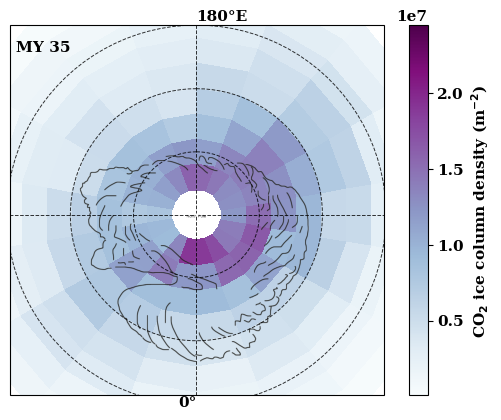

In [20]:
glob_min = np.min([MY29Den.min(),MY30Den.min(),MY31Den.min(),MY32Den.min(),MY33Den.min(),MY34Den.min(),MY35Den.min()])
glob_max = np.max([MY29Den.max(),MY30Den.max(),MY31Den.max(),MY32Den.max(),MY33Den.max(),MY34Den.max(),MY35Den.max()])


img = plt.imread("North_Pole_Outline.png")
k = 1.7e6 #scaling for my custom background image, i literally have no idea why this is the value but im not questioning it

mplot = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0.0, globe=None))
mplot.set_global()
mplot.set_extent([-180,180,75,90], ccrs.PlateCarree())
gl = mplot.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=0.7, color='black', alpha=0.8, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([85,80,75])
gl.xlocator = mticker.FixedLocator([0,90,180,-90])
gl.xlocator = mticker.FixedLocator([0,90,180,-90])
gl.xlabel_style = {'color': 'black', 'weight': 'bold','rotation':0}
gl.ylabel_style = {'size': 10, 'color': 'black'}
gl.top_labels=True
gl.bottom_labels=True


yrchoice = MY35Den
clouds = mplot.pcolormesh(longrange+10,latrange[:-1]+1,yrchoice,vmin=glob_min, vmax=glob_max,transform=ccrs.PlateCarree(),cmap = 'BuPu')
mplot.imshow(img,extent = [-k, k, -k, k-2e4], transform = ccrs.NorthPolarStereo(central_longitude=0.0),zorder=1 )
cb = plt.colorbar(clouds)
cb.set_label(label = 'CO$_2$ ice column density (m$^{-2}$) ',weight='bold')
plt.text(-1.6e6,1.45e6,'MY 35', weight= 'bold')
plt.show()
#plt.savefig('MY35_North_Pole_Cloud_Densities.png',transparent = True,dpi = 300)

In [1292]:
#LOAD IN SOUTH RESULTS
#to read the data for plotting:
# Load data (deserialize)
with open('../Results/32MICRON_South_Snowfall_Results_No_Outliers.pickle', 'rb') as handle:
    South_results = pickle.load(handle)

In [1302]:
#read results in for South

Water_deposit29  =  South_results['Water_deposit29'] 
CO2_deposit29    =  South_results['CO2_deposit29']   
Mass_deposit29   =  South_results['Mass_deposit29']  
CMass_deposit29  =  South_results['CMass_deposit29'] 
Water_cum29      =  South_results['Water_cum29']       
Mass_cum29       =  South_results['Mass_cum29']        
DryIce_cum29     =  South_results['DryIce_cum29']      
CMass_cum29      =  South_results['CMass_cum29']       

#MY30
Water_deposit30 =  South_results['Water_deposit30'] 
CO2_deposit30   =  South_results['CO2_deposit30']   
Mass_deposit30  =  South_results['Mass_deposit30']  
CMass_deposit30 =  South_results['CMass_deposit30'] 
Water_cum30     =  South_results['Water_cum30']       
Mass_cum30      =  South_results['Mass_cum30']        
DryIce_cum30    =  South_results['DryIce_cum30']      
CMass_cum30     =  South_results['CMass_cum30']       

#MY31
Water_deposit31 =  South_results['Water_deposit31'] 
CO2_deposit31   =  South_results['CO2_deposit31']   
Mass_deposit31  =  South_results['Mass_deposit31']  
CMass_deposit31 =  South_results['CMass_deposit31'] 
Water_cum31     =  South_results['Water_cum31']       
Mass_cum31      =  South_results['Mass_cum31']        
DryIce_cum31    =  South_results['DryIce_cum31']      
CMass_cum31     =  South_results['CMass_cum31']       

#MY32
Water_deposit32 =  South_results['Water_deposit32'] 
CO2_deposit32   =  South_results['CO2_deposit32']   
Mass_deposit32  =  South_results['Mass_deposit32']  
CMass_deposit32 =  South_results['CMass_deposit32'] 
Water_cum32     =  South_results['Water_cum32']       
Mass_cum32      =  South_results['Mass_cum32']        
DryIce_cum32    =  South_results['DryIce_cum32']      
CMass_cum32     =  South_results['CMass_cum32']       

#MY33
Water_deposit33 =  South_results['Water_deposit33'] 
CO2_deposit33   =  South_results['CO2_deposit33']   
Mass_deposit33  =  South_results['Mass_deposit33']  
CMass_deposit33 =  South_results['CMass_deposit33'] 
Water_cum33     =  South_results['Water_cum33']       
Mass_cum33      =  South_results['Mass_cum33']        
DryIce_cum33    =  South_results['DryIce_cum33']      
CMass_cum33     =  South_results['CMass_cum33']       

#MY34
Water_deposit34 =  South_results['Water_deposit34'] 
CO2_deposit34   =  South_results['CO2_deposit34']   
Mass_deposit34  =  South_results['Mass_deposit34']  
CMass_deposit34 =  South_results['CMass_deposit34'] 
Water_cum34     =  South_results['Water_cum34']       
Mass_cum34      =  South_results['Mass_cum34']        
DryIce_cum34    =  South_results['DryIce_cum34']      
CMass_cum34  =  South_results['CMass_cum34']       


#MY35
Water_deposit35 =  South_results['Water_deposit35'] 
CO2_deposit35   =  South_results['CO2_deposit35']   
Mass_deposit35  =  South_results['Mass_deposit35']  
CMass_deposit35 =  South_results['CMass_deposit35'] 
Water_cum35     =  South_results['Water_cum35']       
Mass_cum35      =  South_results['Mass_cum35']        
DryIce_cum35    =  South_results['DryIce_cum35']      
CMass_cum35  =  South_results['CMass_cum35'] 

#calculate the average co2 snowfall per year
CO2_stack = np.stack([CO2_deposit29,CO2_deposit30,CO2_deposit31,CO2_deposit32,CO2_deposit33,CO2_deposit34 ,CO2_deposit35])
CO2_median = np.median(CO2_stack, axis = 0)
CO2_mean = np.mean(CO2_stack, axis = 0)
#TOTAL CO2 MULTIPLE YEARS AVERAGE
sigmaval = 3
smooth_avCO2 = gaussian_filter(CO2_median, sigma=sigmaval)
avCO2_total = np.nanmean(smooth_avCO2, axis = 1)

#create the latitude arrays associated with the results in the previous two cells for the norht and south pole>
LatV = np.linspace(-87,-65,23)

In [1307]:
#Read in Vortex Area dataframe:
Vortex_Areas = pd.read_csv('../Results/Vortex_Areas_SouthWinter_MY29-35.zip')  

#Read in Vortex Temps dataframe:
Vortex_Temps = pd.read_csv('../Results/Vortex_Temps_SouthWinter_MY29-35.zip')  

#calculate the av temps one way
Vortex_Temps['MnTemp'] = Vortex_Temps[['Temp29', 'Temp30','Temp31','Temp32','Temp33','Temp35']].median(axis=1)
Vortex_Temps['MnFrostTemp'] = Vortex_Temps[['Tfrost29', 'Tfrost30','Tfrost31','Tfrost32','Tfrost33','Tfrost35']].median(axis=1)

In [1309]:
#Create Masks for the temperature plots over the times where there are dust storms, so that I can get the average baseline without duststorm effects
#define the edges of the boundaries for the masks
m29_edges = np.array([(139,180)])
m31_edges = np.array([(152,180)])
m32_edges = np.array([(152,180)])
m33_edges = np.array([(150,180)])
m34_edges = np.array([(161,180)])
m35_edges = np.array([(34,46),(162,180)])

window = 4
order = 1

smooth_diff29   =   savgol_filter(np.array(Vortex_Temps['Temp29'])-np.array(Vortex_Temps['Tfrost29']),window, order)
smooth_diff30   =   savgol_filter(np.array(Vortex_Temps['Temp30'])-np.array(Vortex_Temps['Tfrost30']),window, order)
smooth_diff31   =   savgol_filter(np.array(Vortex_Temps['Temp31'])-np.array(Vortex_Temps['Tfrost31']),window, order)
smooth_diff32   =   savgol_filter(np.array(Vortex_Temps['Temp32'])-np.array(Vortex_Temps['Tfrost32']),window, order)
smooth_diff33   =   savgol_filter(np.array(Vortex_Temps['Temp33'])-np.array(Vortex_Temps['Tfrost33']),window, order)
smooth_diff34   =   savgol_filter(np.array(Vortex_Temps['Temp34'])-np.array(Vortex_Temps['Tfrost34']),window, order)
smooth_diff35   =   savgol_filter(np.array(Vortex_Temps['Temp35'])-np.array(Vortex_Temps['Tfrost35']),window, order)


T29  = smooth_diff29
T30  = smooth_diff30
T31  = smooth_diff31
T32  = smooth_diff32
T33  = smooth_diff33
T34  = smooth_diff34
T35  = smooth_diff35


Av_Temp_diff = np.nanmean([T29,T30,T31,T32,T33,T34,T35],axis=0)

smoothed_temp_diff =  savgol_filter(Av_Temp_diff,6, 1)

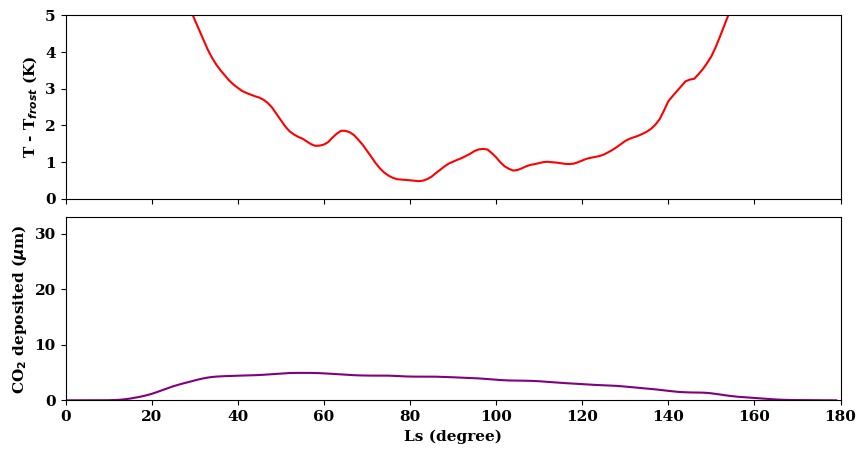

In [1310]:
#plot the temp diff with co2 snowfall for south

fullnames = np.linspace(0,180,181)
figure, (ax0,ax1) = plt.subplots(2, 1, figsize=(10,5), sharex=True)

plt.subplots_adjust(hspace=.1)
#ax0.plot(Vortex_Temps['Ls'],Vortex_Temps['MnTemp']-Vortex_Temps['MnFrostTemp'],'r')
ax0.plot(Vortex_Temps['Ls'],smoothed_temp_diff,'r')


ax0.set_xlim(0,180)
ax0.set_ylim(0,5)
ax0.set_ylabel('T - T$_{frost}$ (K)',weight = 'bold')

ax1.plot(fullnames[:-1],avCO2_total*1e6,color = 'purple')
ax1.set_ylabel('CO$_2$ deposited ($\mu$m)', weight='bold')
ax1.set_ylim(0,33)
ax1.set_xlabel('Ls (degree)',fontweight='bold')


plt.savefig("Solstitial_South_Warming.png", dpi=200)

In [9]:
#polar density plots

#first download the data
Polar_Clouds35 = pd.read_csv('../Results/MY35_SouthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds34 = pd.read_csv('../Results/MY34_SouthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds33 = pd.read_csv('../Results/MY33_SouthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds32 = pd.read_csv('../Results/MY32_SouthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds31 = pd.read_csv('../Results/MY31_SouthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds30 = pd.read_csv('../Results/MY30_SouthWinter_Longitude_Clouds_70-88.zip')
Polar_Clouds29 = pd.read_csv('../Results/MY29_SouthWinter_Longitude_Clouds_70-88.zip')

#then re-arrange and group the data by longitude for plotting purposes
MY29Den = np.full([9,18],np.nan) ; MY30Den = np.full([9,18],np.nan) ; MY31Den = np.full([9,18],np.nan)
MY32Den = np.full([9,18],np.nan) ; MY33Den = np.full([9,18],np.nan) ; MY34Den = np.full([9,18],np.nan)
MY35Den = np.full([9,18],np.nan)

latmin = -88
latmax = -70
latbinsiz = 2
latrange = np.arange(latmin,latmax+1,latbinsiz)
longrange = np.array(list(Polar_Clouds29[(Polar_Clouds29.Lat==latrange[0])].groupby('Long').groups.keys()))

for i in range(0,9):
    MY29Den[i] = Polar_Clouds29[(Polar_Clouds29.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY30Den[i] = Polar_Clouds30[(Polar_Clouds30.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY31Den[i] = Polar_Clouds31[(Polar_Clouds31.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY32Den[i] = Polar_Clouds32[(Polar_Clouds32.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY33Den[i] = Polar_Clouds33[(Polar_Clouds33.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY34Den[i] = Polar_Clouds34[(Polar_Clouds34.Lat==latrange[i])].groupby('Long').mean().ColDen.values
    MY35Den[i] = Polar_Clouds35[(Polar_Clouds35.Lat==latrange[i])].groupby('Long').mean().ColDen.values

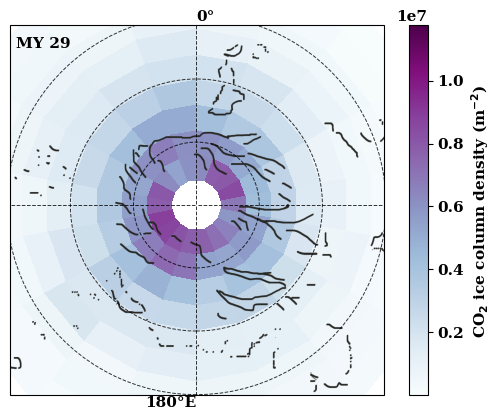

In [13]:
#Creating the plot of co2 density spatial distribution

glob_min = np.min([MY29Den.min(),MY30Den.min(),MY31Den.min(),MY32Den.min(),MY33Den.min(),MY34Den.min(),MY35Den.min()])
glob_max = np.max([MY29Den.max(),MY30Den.max(),MY31Den.max(),MY32Den.max(),MY33Den.max(),MY34Den.max(),MY35Den.max()])

img = plt.imread("South_Pole_Outline.png")
k = 1.7e6 #scaling for my custom background image, i literally have no idea why this is the value but im not questioning it

mplot = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0.0, globe=None))
mplot.set_global()
mplot.set_extent([-180,180,-75,-90], ccrs.PlateCarree())
gl = mplot.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=0.7, color='black', alpha=0.8, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylocator = mticker.FixedLocator([-75,-80,-85,-90])
gl.xlocator = mticker.FixedLocator([0,90,180,-90])
gl.xlabel_style = {'color': 'black', 'weight': 'bold','rotation':0}
gl.ylabel_style = {'size': 10, 'color': 'black'}
gl.top_labels=True
gl.bottom_labels=True

yrchoice = MY29Den
clouds = mplot.pcolormesh(longrange+10,latrange[:-1]+1,yrchoice,vmin=glob_min, vmax=glob_max,transform=ccrs.PlateCarree(),cmap = 'BuPu')
mplot.imshow(img,extent = [-k, k, -k, k-2e4], transform = ccrs.SouthPolarStereo(central_longitude=0.0),zorder=1 )
cb = plt.colorbar(clouds)
cb.set_label(label = 'CO$_2$ ice column density (m$^{-2}$) ',weight='bold')
plt.text(-1.6e6,1.4e6,'MY 29', weight= 'bold')
plt.show()
#plt.savefig('MY29_South_Pole_Cloud_Densities.png',transparent = True,dpi = 300)